In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

import pandas as pd
from collections import defaultdict, Counter

In [2]:
def gaussian(x, sigma):
	return np.exp(-x**2 / (2 * sigma ** 2))

def gaussian_ricker(x, sigma):
	return - (x**2 - sigma**2) / sigma**4 * gaussian(x, sigma)

def chess_map(size1, size2):
	return np.array([(i, j) for i in range(size1) for j in range(size2)])

def civilization_map(size1, size2):
	return np.array([(i, j*np.sqrt(3)/2) if (j % 2) else (i+1/2, j*np.sqrt(3)/2) for i in range(size1) for j in range(size2)])

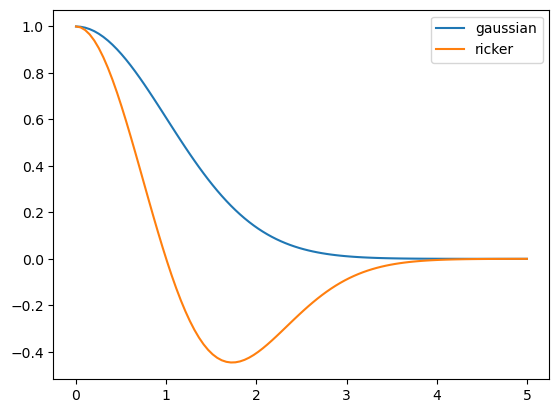

In [43]:
x = np.linspace(0, 5, 100)
sigma = 1

gauss = gaussian(x, sigma)
gauss_2 = gaussian_ricker(x, sigma)

plt.plot(x, gauss, label='gaussian')
plt.plot(x, gauss_2, label='ricker')
plt.legend()

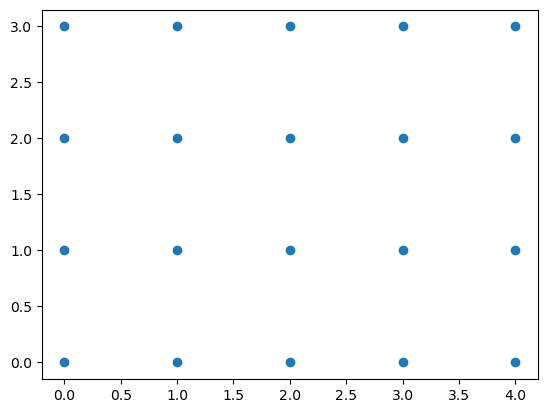

In [4]:
weights_index = chess_map(5, 4)

x = [w[0] for w in weights_index]
y = [w[1] for w in weights_index]

plt.scatter(x, y)

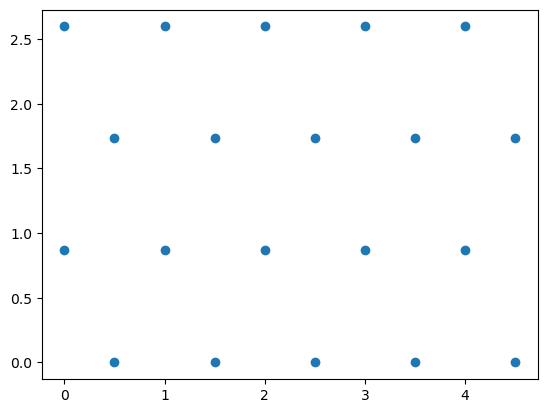

In [60]:
weights_index = civilization_map(5, 4)

x = [w[0] for w in weights_index]
y = [w[1] for w in weights_index]

plt.scatter(x, y)

In [ ]:
class KohonenMap:
	def __init__(self, map_size, map_shape):
		# initiate grid size and shape
		self.map_dims = (map_size[0], map_size[1])
		if map_shape == 'chess':
			self.weights_index = chess_map(map_size[0], map_size[1])
		elif map_shape == 'civilization':
			self.weights_index = civilization_map(map_size[0], map_size[1])
		else: 
			raise Exception("Choose map_shape as 'chess' or 'civilization'")
		# set epsilon for dumping factor
		self.epsilon = np.finfo(float).eps

	def visualize(self, observations, labels, prediction, show_neurons=True):
		labels = labels.ravel()
		prediction_ids = np.ravel_multi_index(prediction.T.astype(int), dims=self.map_dims)

		unique_labels = np.unique(labels)
		unique_predictions = np.unique(prediction_ids)
		cmap_labels = plt.cm.get_cmap('tab10', len(unique_labels))
		cmap_predictions = plt.cm.get_cmap('tab10', len(unique_predictions))

		print("SOM clusters:", len(unique_predictions))
		print("True clusters:", len(unique_labels))

		fig = plt.figure(figsize=(10, 5))
		is_3d = observations.shape[1] == 3

		# Plot 1: Original Labels
		ax1 = fig.add_subplot(1, 2, 1, projection='3d' if is_3d else None)
		for i, label in enumerate(unique_labels):
			idx = labels == label
			ax1.scatter(*observations[idx].T, color=cmap_labels(i), label=f'Class {label}')
		ax1.set_title('Original Labels')
		ax1.set_xlabel('X')
		ax1.set_ylabel('Y')
		if is_3d:
			ax1.set_zlabel('Z')

		# Plot 2: SOM Predictions + Neuron positions
		ax2 = fig.add_subplot(1, 2, 2, projection='3d' if is_3d else None)
		for i, cluster in enumerate(unique_predictions):
			idx = prediction_ids == cluster
			ax2.scatter(*observations[idx].T, color=cmap_predictions(i))
		
		if show_neurons:
			# Flatten weights for scatter
			flat_weights = self.weights.reshape(-1, observations.shape[1])
			ax2.scatter(*flat_weights.T, marker='x', color='black', label='Neurons')

		ax2.set_title('SOM Predictions')
		ax2.set_xlabel('X')
		ax2.set_ylabel('Y')
		if is_3d:
			ax2.set_zlabel('Z')
		ax2.legend()
		plt.tight_layout()
		plt.show()
		
	def visualize_old(self, observations, labels, prediction):
		labels = labels.ravel()
		prediction_ids = np.ravel_multi_index(prediction.T.astype(int), dims=self.map_dims)

		unique_labels = np.unique(labels)
		unique_predictions = np.unique(prediction_ids)
		cmap_labels = plt.cm.get_cmap('tab10', len(unique_labels))
		cmap_predictions = plt.cm.get_cmap('tab10', len(unique_predictions))

		print("SOM clusters:", len(unique_predictions))
		print("True clusters:", len(unique_labels))

		if observations.shape[1] == 2:
			fig = plt.figure(figsize=(10, 5))
			ax1 = fig.add_subplot(1, 2, 1)
			for i, label in enumerate(unique_labels):
				idx = labels == label
				ax1.scatter(observations[idx, 0], observations[idx, 1], color=cmap_labels(i))
			ax1.set_title('Original Labels')
			ax1.set_xlabel('X')
			ax1.set_ylabel('Y')

			ax2 = fig.add_subplot(1, 2, 2)
			for i, cluster in enumerate(unique_predictions):
				idx = prediction_ids == cluster
				ax2.scatter(observations[idx, 0], observations[idx, 1], color=cmap_predictions(i))
			ax2.set_title('SOM Predictions')
			ax2.set_xlabel('X')
			ax2.set_ylabel('Y')

		elif observations.shape[1] == 3:
			fig = plt.figure(figsize=(10, 5))
			ax1 = fig.add_subplot(1, 2, 1, projection='3d')
			for i, label in enumerate(unique_labels):
				idx = labels == label
				ax1.scatter(observations[idx, 0], observations[idx, 1], observations[idx, 2],
							color=cmap_labels(i))
			ax1.set_title('Original Labels')
			ax1.set_xlabel('X')
			ax1.set_ylabel('Y')
			ax1.set_zlabel('Z')

			ax2 = fig.add_subplot(1, 2, 2, projection='3d')
			for i, cluster in enumerate(unique_predictions):
				idx = prediction_ids == cluster
				ax2.scatter(observations[idx, 0], observations[idx, 1], observations[idx, 2],
							color=cmap_predictions(i))
			ax2.set_title('SOM Predictions')
			ax2.set_xlabel('X')
			ax2.set_ylabel('Y')
			ax2.set_zlabel('Z')

		plt.tight_layout()
		plt.show()

	def learn(self, observations, iterations_num, step=None, map_range=None, influence_func='gaussian'):
		# set hyper parameters if not given
		if step is None:
			step = 0.1
		if map_range is None:
			map_range = np.min(self.map_dims) // 2
		
		# set dumping factor
		self.dumping_factor = len(observations)/np.log(map_range + self.epsilon)

		# initialze weights aroudn centroid
		centroid = np.mean(observations, axis=0)
		data_dims = observations.shape[1]
		self.weights = np.random.normal(loc = centroid, scale=0.1, size=(self.map_dims[0], self.map_dims[1], data_dims))
		# print("Centroid:", centroid)
		# print("Mean of weights:", self.weights.mean(axis=(0, 1)))

		# perform learning
		for iteration in range(iterations_num):
			# go over data
			randomized_observations = self.randomize_observations_order(observations)
			for time, observation in enumerate(randomized_observations):
				# check all errors
				error = self.check_error(observation)
				# pick smallest error
				bmu = self.check_BMU(error)
				# find distances to bmu
				distance = self.check_distance(bmu)
				# find update overflow from bmu 
				if influence_func == 'gaussian':
					influence = gaussian(distance, map_range)
				if influence_func == 'gaussian_ricker':
					influence = gaussian_ricker(distance, map_range)
				# update weights
				self.weights += step * influence[:,:,np.newaxis] * error

			# update hyper parameters
			map_range, step = self.check_parameters(time, map_range, step)
			# print('time', time)
			# print('map_range', map_range)
			# print('step', step)

	def check_distance(self, bmu):
		# check distances in map coordinates from the given neuron 
		distance = np.linalg.norm(bmu - self.weights_index, axis=1).reshape(self.map_dims)
		return distance

	def check_error(self, observation):
		# check error between neurons and data
		error = observation - self.weights
		return error
		
	def check_BMU(self, error):
		# find coordinates of neuron most simmilar to observation
		similarity = np.linalg.norm(error, axis=-1)
		bmu = np.array(np.unravel_index(np.argmin(similarity), similarity.shape))
		return bmu
	
	def check_parameters(self, time, map_range, step):
		# update range modifier and step size for weights update
		new_range = map_range * np.exp(-time/self.dumping_factor)
		new_step = step * np.exp(-time/self.dumping_factor)
		return new_range, new_step
	
	def predict(self, observations):
		# cluster data based on current weights
		clasters = np.empty((len(observations), 2))
		for time, observation in enumerate(observations):
			error = self.check_error(observation)
			bmu = self.check_BMU(error)
			clasters[time] = bmu
		return clasters

	def get_error_matrix(self, labels, predictions):
		neuron_class_counts = defaultdict(Counter)

		for i, bmu in enumerate(predictions.astype(int)):
			neuron_id = tuple(bmu)
			label = labels[i]
			if isinstance(label, np.ndarray):
				label = label.item()
			neuron_class_counts[label][neuron_id] += 1

		# Convert to DataFrame for readability
		all_labels = sorted(neuron_class_counts.keys())
		all_neurons = sorted({nid for c in neuron_class_counts.values() for nid in c})
		neuron_strs = [str(nid) for nid in all_neurons]

		data = []
		for label in all_labels:
			row = [neuron_class_counts[label].get(nid, 0) for nid in all_neurons]
			data.append(row)

		df = pd.DataFrame(data, index=all_labels, columns=neuron_strs)
		return df

	def randomize_observations_order(self, observations):
		return observations[np.random.permutation(len(observations))]
	
	def check_accuracy(self, data, labels, prediction):
		prediction_labels = np.empty(len(prediction))
		sight = len(prediction) // len(np.unique(labels))
		for num, (i, j) in enumerate(prediction):
			neuron = self.weights[i, j]
			distances = np.linalg.norm(data - neuron, axis=1)
			closeby_labels = labels[np.argsort(distances)[:sight]].astype(int)
			prediction_labels[num] = np.bincount(closeby_labels).argmax()

		return np.sum(prediction_labels == labels) / len(labels)

# MNIST

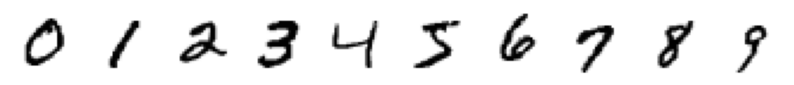

In [7]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

mnist_y = mnist.target
mnist_x = mnist.data.to_numpy()

mnist_exemplar = [1, 3, 5, 7, 2, 0, 13, 15, 17, 19]

plt.figure(figsize=(10, 10))
for i in range(10):
    image_id = mnist_exemplar[i]
    plt.subplot(1, 10, i + 1)
    plt.imshow(mnist_x[image_id].reshape(28,28), cmap='binary')
    plt.axis('off')
plt.show()

In [13]:
koh_mnist = KohonenMap((1, 9), map_shape='chess')

koh_mnist.learn(mnist_x, iterations_num=20, step=0.1, map_range=5, influence_func='gaussian')

In [25]:
prediction_mnist = koh_mnist.predict(mnist_x)

koh_mnist.get_error_matrix(mnist_y, prediction_mnist)

# koh_mnist.check_accuracy(mnist_x, mnist_y, prediction_mnist)

,"(np.int64(0), np.int64(0))","(np.int64(0), np.int64(1))","(np.int64(0), np.int64(2))","(np.int64(0), np.int64(3))","(np.int64(0), np.int64(4))","(np.int64(0), np.int64(5))","(np.int64(0), np.int64(6))","(np.int64(0), np.int64(7))","(np.int64(0), np.int64(8))"
0,7,22,748,19,42,247,44,5478,296
1,4300,3528,8,10,6,6,9,0,10
2,449,425,154,87,206,217,4933,69,450
3,532,69,1198,60,189,64,259,35,4735
4,213,292,46,2309,3698,205,46,14,1
5,262,635,2322,289,441,126,17,68,2153
6,395,145,288,3,97,5693,126,92,37
7,385,335,11,4456,2018,5,57,22,4
8,399,348,3593,282,257,57,61,38,1790
9,288,109,81,2907,3384,14,20,50,105


# HARUS

In [47]:
def read_harus(filename):
    with open(filename, 'r') as file:
        data = []
        for line in file:
            row = [float(x) for x in line.split()]
            data.append(row)
    return np.array(data)

HARUS_train_x = read_harus('../data/harus/train/X_train.txt')
HARUS_train_y = read_harus('../data/harus/train/X_train.txt').flatten().astype(int)

HARUS_test_x = read_harus('../data/harus/test/X_test.txt')
HARUS_test_y = read_harus('../data/harus/test/X_test.txt').flatten().astype(int)

In [58]:
koh_harus = KohonenMap((3, 3), map_shape='civilization')

koh_harus.learn(HARUS_train_x, iterations_num=25, step=0.1, map_range=1.5, influence_func='gaussian')

In [59]:
prediction_harus = koh_harus.predict(HARUS_train_x)

koh_harus.get_error_matrix(HARUS_train_y, prediction_harus)

# koh_harus.check_accuracy(HARUS_train_y, prediction_harus)

,"(np.int64(0), np.int64(0))","(np.int64(0), np.int64(1))","(np.int64(0), np.int64(2))","(np.int64(1), np.int64(0))","(np.int64(1), np.int64(1))","(np.int64(1), np.int64(2))","(np.int64(2), np.int64(0))","(np.int64(2), np.int64(1))","(np.int64(2), np.int64(2))"
-1,24,27,9,6,45,18,4,29,27
0,1258,1243,250,318,1974,617,247,712,540
1,0,1,0,0,2,0,0,1,0


# HEXAGON

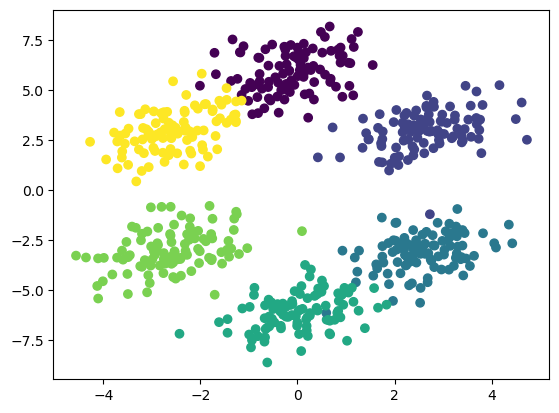

In [27]:
hexagon = pd.read_csv('../data/koh/mio2/hexagon.csv')

hexagon_X = np.array(hexagon[['x', 'y']])
hexagon_Y = np.array(hexagon[['c']])

plt.scatter(hexagon_X[:, 0], hexagon_X[:, 1], c=hexagon_Y.flatten(), cmap='viridis')

/tmp/ipykernel_1045/3241520429.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_labels = plt.cm.get_cmap('tab10', len(unique_labels))
/tmp/ipykernel_1045/3241520429.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_predictions = plt.cm.get_cmap('tab10', len(unique_predictions))


SOM clusters: 6
True clusters: 6


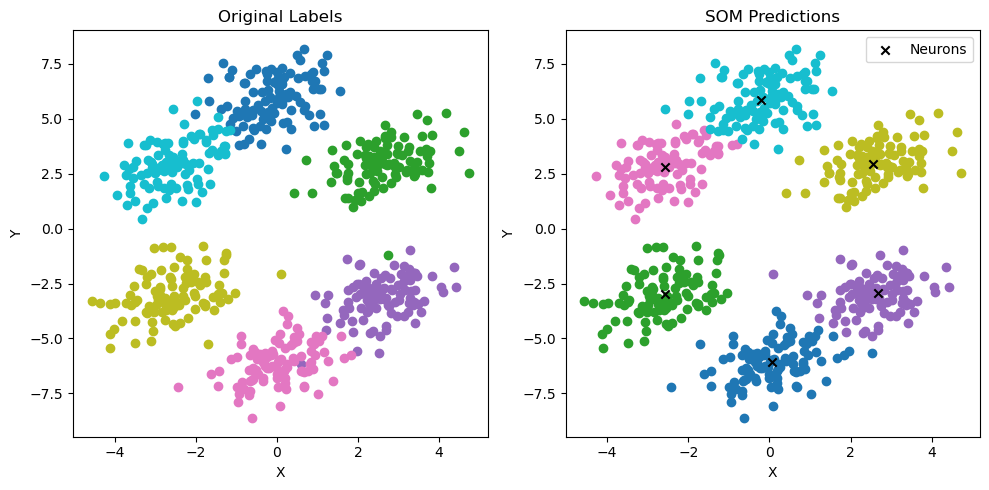

,"(np.int64(0), np.int64(0))","(np.int64(0), np.int64(1))","(np.int64(1), np.int64(0))","(np.int64(1), np.int64(1))","(np.int64(2), np.int64(0))","(np.int64(2), np.int64(1))"
0,0,0,0,2,0,98
1,0,0,1,0,99,0
2,4,0,96,0,0,0
3,100,0,0,0,0,0
4,1,98,1,0,0,0
5,0,0,0,94,0,6


In [55]:
koh_hexagon = KohonenMap((3, 2), map_shape='chess')

koh_hexagon.learn(hexagon_X, iterations_num=5, step=0.2, map_range=2, influence_func='gaussian')

prediction_hexagon = koh_hexagon.predict(hexagon_X)

koh_hexagon.visualize(hexagon_X, hexagon_Y, prediction_hexagon, show_neurons=True)

koh_hexagon.get_error_matrix(hexagon_Y, prediction_hexagon)

# CUBE

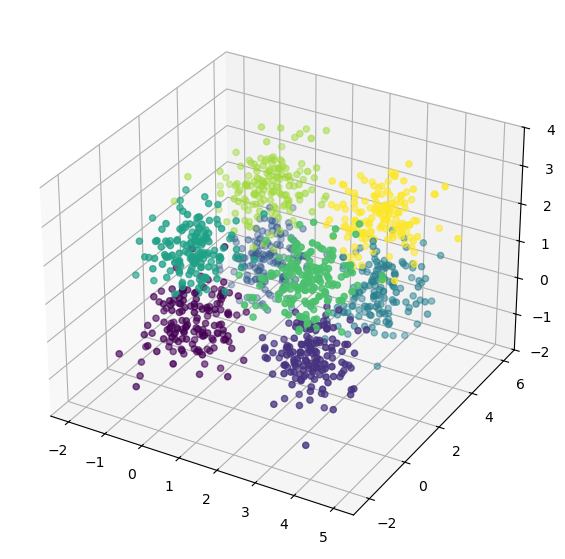

In [30]:
cube = pd.read_csv('../data/koh/mio2/cube.csv')

cube_X = np.array(cube[['x', 'y', 'z']])
cube_Y = np.array(cube[['c']])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
plot = ax.scatter(cube_X[:, 0], cube_X[:, 1], cube_X[:, 2], c=cube_Y.flatten(), cmap='viridis')

/tmp/ipykernel_1045/3241520429.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_labels = plt.cm.get_cmap('tab10', len(unique_labels))
/tmp/ipykernel_1045/3241520429.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_predictions = plt.cm.get_cmap('tab10', len(unique_predictions))


SOM clusters: 8
True clusters: 8


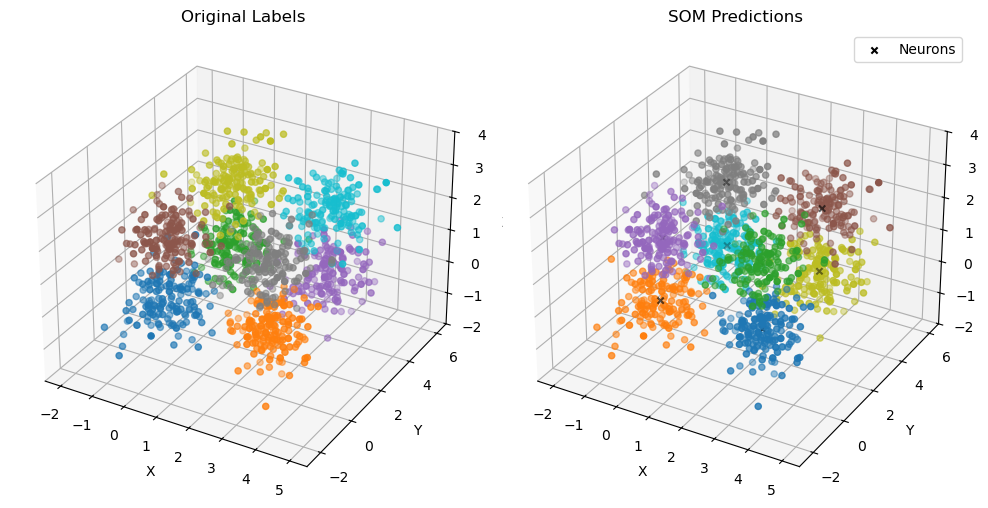

,"(np.int64(0), np.int64(0))","(np.int64(0), np.int64(1))","(np.int64(1), np.int64(0))","(np.int64(1), np.int64(1))","(np.int64(2), np.int64(0))","(np.int64(2), np.int64(1))","(np.int64(3), np.int64(0))","(np.int64(3), np.int64(1))"
0,0,144,0,6,0,0,0,0
1,149,0,1,0,0,0,0,0
2,0,0,0,0,0,3,1,146
3,0,0,0,0,6,0,143,1
4,0,3,0,147,0,0,0,0
5,5,0,143,2,0,0,0,0
6,0,0,0,0,0,144,0,6
7,0,0,0,0,141,0,9,0


In [36]:
koh_cube = KohonenMap(map_size = (4, 2), map_shape='chess')

koh_cube.learn(cube_X, iterations_num=10, step=0.1, map_range=2, influence_func='gaussian')

prediction_cube = koh_cube.predict(cube_X)

koh_cube.visualize(cube_X, cube_Y, prediction_cube)

koh_hexagon.get_error_matrix(cube_Y, prediction_cube)